<a href="https://colab.research.google.com/github/Parveenkumar645/Sentiment-Analysis-of-Social-media-post/blob/main/Sentiment_Analysis_of_Social_Media.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data
import pandas as pd
import numpy as np
import re

# Visualization
import matplotlib.pyplot as plt

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# ML / DL
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
train_path = "/content/twitter_training.csv"
test_path  = "/content/twitter_validation.csv"

train_df = pd.read_csv(
    train_path,
    names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"]
)

test_df = pd.read_csv(
    test_path,
    names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"]
)

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

print(train_df.shape, test_df.shape)


(68397, 4) (1000, 4)


In [ ]:
class_to_index = {
    "Neutral": 0,
    "Irrelevant": 1,
    "Negative": 2,
    "Positive": 3
}

index_to_class = {v:k for k,v in class_to_index.items()}

train_df["Sentiment"] = train_df["Sentiment"].map(class_to_index)
test_df["Sentiment"]  = test_df["Sentiment"].map(class_to_index)


In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(w)
        for w in tokens
        if w.isalpha() and w not in stop_words
    ]
    return " ".join(tokens)

train_df["clean_text"] = train_df["Tweet_Content"].apply(clean_text)
test_df["clean_text"]  = test_df["Tweet_Content"].apply(clean_text)


In [ ]:
MAX_WORDS = 20000
MAX_LEN   = 60

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_text"])

X_train_seq = tokenizer.texts_to_sequences(train_df["clean_text"])
X_test_seq  = tokenizer.texts_to_sequences(test_df["clean_text"])

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding='post')

y_train = train_df["Sentiment"]
y_test  = test_df["Sentiment"]


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=4,
            restore_best_weights=True
        )
    ],
    verbose=1
)


Epoch 1/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 145s 302ms/step - accuracy: 0.9591 - loss: 0.0934 - val_accuracy: 0.4560 - val_loss: 4.9883
Epoch 2/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 146s 303ms/step - accuracy: 0.9567 - loss: 0.0992 - val_accuracy: 0.4658 - val_loss: 4.8811
Epoch 3/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 155s 322ms/step - accuracy: 0.9611 - loss: 0.0902 - val_accuracy: 0.4689 - val_loss: 5.1597
Epoch 4/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 150s 312ms/step - accuracy: 0.9625 - loss: 0.0858 - val_accuracy: 0.4680 - val_loss: 5.2749
Epoch 5/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 194s 296ms/step - accuracy: 0.9616 - loss: 0.0851 - val_accuracy: 0.4732 - val_loss: 5.6594
Epoch 6/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 203s 298ms/step - accuracy: 0.9641 - loss: 0.0819 - val_accuracy: 0.4687 - val_loss: 5.2622
Epoch 7/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 143s 297ms/step - accuracy: 0.9629 - loss: 0.0814 - val_accuracy: 0.4583 - val_loss: 5.2909
Epoch 8/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 141s 292ms/step - accuracy: 0.9641 -

In [18]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)

print("Final Accuracy:", accuracy_score(y_test, y_pred))


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step
Final Accuracy: 0.87


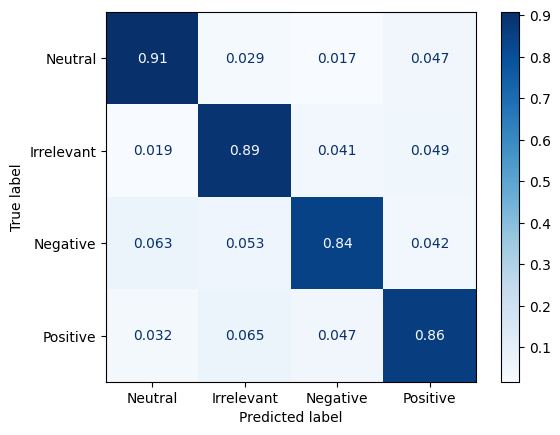

In [19]:
y_test_labels = [index_to_class[i] for i in y_test]
y_pred_labels = [index_to_class[i] for i in y_pred]

cm = confusion_matrix(y_test_labels, y_pred_labels, normalize='true')

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(index_to_class.values())
)
disp.plot(cmap="Blues")
plt.show()
